<a href="https://colab.research.google.com/github/ssm951/chinese-genealogy/blob/main/BERT-Ancient-Chinese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Experimenting

## BERT

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForTokenClassification, TFAutoModelForTokenClassification, TFBertModel, BertModel
import numpy as np
import requests
from sklearn import preprocessing
import torch
from torch import nn, optim
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
def re_label_to_spacy(label):
  split = label.split('_')
  if len(split) == 1:
    return 'O'
  split[1] = split[1].replace('\n','').lower()
  if split[1] == 'person':
    return split[0] + '-PERSON'
  elif split[1] == 'location':
    return split[0] + '-LOC'
  elif split[1] == 'time':
    return split[0] + '-TIME'
  else:
    return 'O'

def extract_data(dataset_path):
  my_file = requests.get(dataset_path).text.split('\n')
  texts = []
  text = ""
  labels = []
  entities = []
  for line in my_file:
    split = line.split(' ')
    if len(split) == 2:
      text += (split[0])
      entities.append(re_label_to_spacy(split[1]))
    else:
      texts.append(text)
      labels.append(entities)
      text = ""
      entities = []
  return texts, labels

prefix = "https://raw.githubusercontent.com/lancopku/Chinese-Literature-NER-RE-Dataset/master/ner/"

train_texts, train_labels = extract_data("{}train.txt".format(prefix))
valid_texts, valid_labels = extract_data("{}validation.txt".format(prefix))

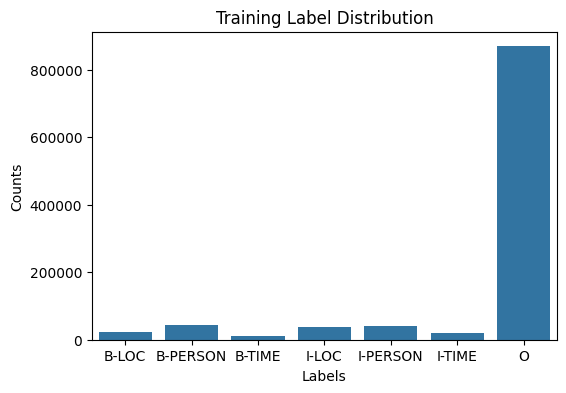

In [107]:
unique_labels, counts = np.unique([label for sublist in train_labels for label in sublist], return_counts=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=unique_labels, y=counts)
plt.title('Training Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

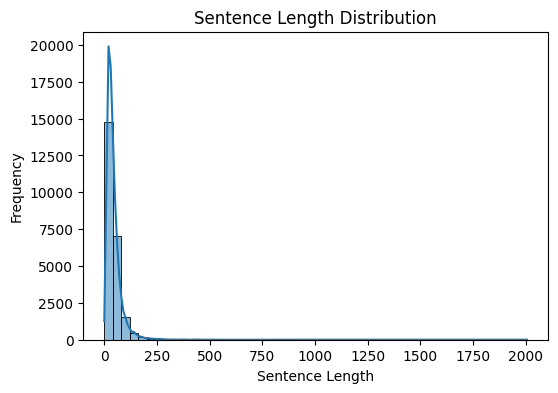

In [111]:
sentence_lengths = [len(sentence) for sentence in train_texts]

plt.figure(figsize=(6, 4))
sns.histplot(sentence_lengths, bins=50, kde=True)
plt.title('Training Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

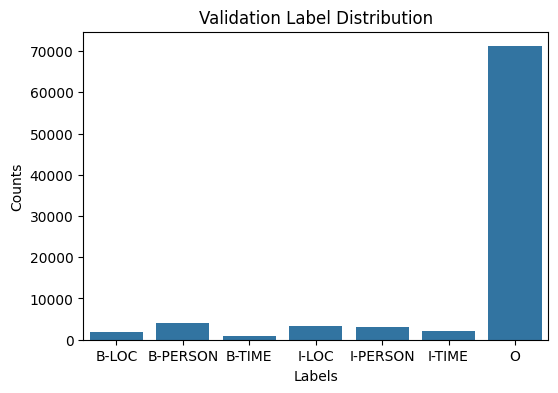

In [108]:
unique_labels, counts = np.unique([label for sublist in valid_labels for label in sublist], return_counts=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=unique_labels, y=counts)
plt.title('Validation Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

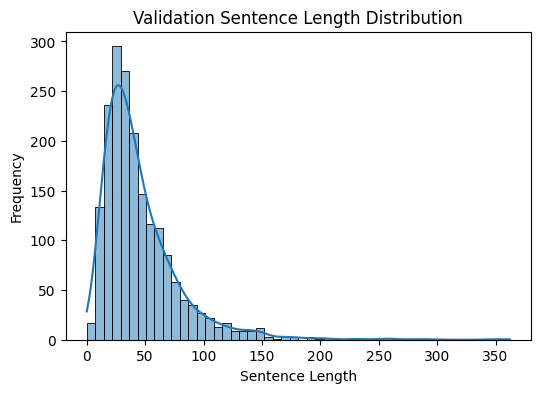

In [112]:
sentence_lengths = [len(sentence) for sentence in valid_texts]

plt.figure(figsize=(6, 4))
sns.histplot(sentence_lengths, bins=50, kde=True)
plt.title('Validation Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
def extract_data_from_file(dataset_path):
  my_file = open(dataset_path, 'r').readlines()
  texts = []
  text = ""
  labels = []
  entities = []
  for line in my_file:
    split = line.strip('\n').split(' ')
    if len(split) == 2:
      text += (split[0])
      entities.append(split[1])
    else:
      texts.append(text)
      labels.append(entities)
      text = ""
      entities = []
  return texts, labels

data_path = '/content/drive/MyDrive/Colab Notebooks/chinese-genealogy/data/'
genealogy_texts, genealogy_labels = [], []
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if not os.path.isdir(folder_path):
        continue
    folder_path = os.path.join(folder_path, 'ner_labeled')
    if not os.path.isdir(folder_path):
        continue
    texts = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        texts, labels = extract_data_from_file(file_path)
        genealogy_texts.extend(texts)
        genealogy_labels.extend(labels)

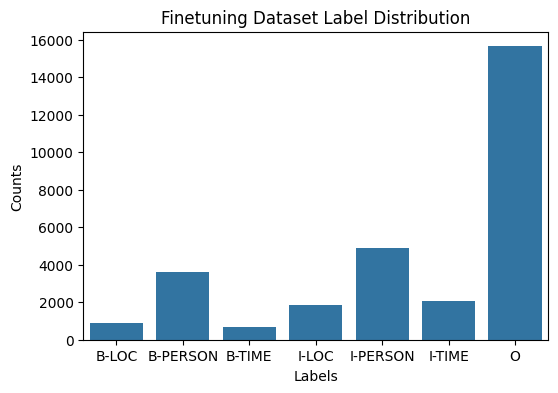

In [109]:
unique_labels, counts = np.unique([label for sublist in genealogy_labels for label in sublist], return_counts=True)

plt.figure(figsize=(6, 4))
sns.barplot(x=unique_labels, y=counts)
plt.title('Finetuning Dataset Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.show()

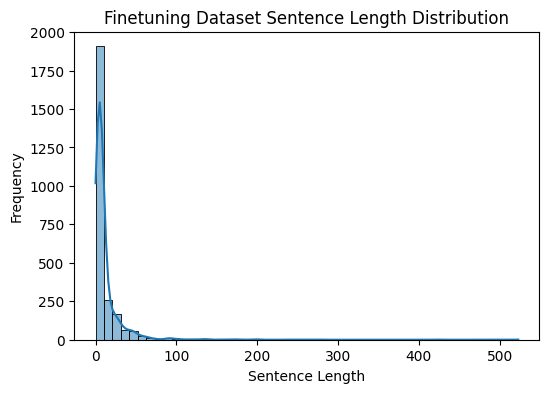

In [113]:
sentence_lengths = [len(sentence) for sentence in genealogy_texts]

plt.figure(figsize=(6, 4))
sns.histplot(sentence_lengths, bins=50, kde=True)
plt.title('Finetuning Dataset Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()

In [92]:
print(f"Number of lines: {len(genealogy_texts)}")
print(f"Number of characters: {len([text for sublist in genealogy_texts for text in sublist])}")

Number of lines: 2522
Number of characters: 29608


In [6]:
max_length = 200
num_labels = 7   # 3 entity classes (B- and I-), plus no class (O)
learning_rate = 0.0001

In [7]:
encoder = preprocessing.LabelEncoder()
encoder.fit([label for sublist in train_labels for label in sublist])

encoded_train_labels = [encoder.transform(label) for label in train_labels]
encoded_valid_labels = [encoder.transform(label) for label in valid_labels]
encoded_genealogy_labels = [encoder.transform(label) for label in genealogy_labels]

padding_char = encoder.transform(['O'])[0]

padded_train_labels = [np.insert(row, 0, padding_char) for row in encoded_train_labels]
padded_valid_labels = [np.insert(row, 0, padding_char) for row in encoded_valid_labels]
padded_genealogy_labels = [np.insert(row, 0, padding_char) for row in encoded_genealogy_labels]

padded_train_labels = tf.keras.preprocessing.sequence.pad_sequences(
    padded_train_labels, maxlen=max_length, truncating="post", padding="post",
    value = padding_char
)
padded_valid_labels = tf.keras.preprocessing.sequence.pad_sequences(
    padded_valid_labels, maxlen=max_length, truncating="post", padding="post",
    value = padding_char
)
padded_genealogy_labels = tf.keras.preprocessing.sequence.pad_sequences(
    padded_genealogy_labels, maxlen=max_length, truncating="post", padding="post",
    value = padding_char
)

train_labels_array = np.array(padded_train_labels)
valid_labels_array = np.array(padded_valid_labels)
genealogy_labels_array = np.array(padded_genealogy_labels)

In [8]:
!pip install iterative-stratification

In [63]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index, test_index in msss.split(genealogy_texts, genealogy_labels_array):
    genealogy_train_texts = [genealogy_texts[i] for i in train_index]
    genealogy_train_labels_array = [genealogy_labels_array[i] for i in train_index]
    genealogy_test_texts = [genealogy_texts[i] for i in test_index]
    genealogy_test_labels_array = [genealogy_labels_array[i] for i in test_index]

In [61]:
# check lengths
for i in range(len(genealogy_texts)):
    if len(genealogy_texts[i]) != len(genealogy_labels_array[i]):
        print(i)
for i in range(len(genealogy_train_texts)):
    if len(genealogy_train_texts[i]) != len(genealogy_train_labels_array[i]):
        print(i)
for i in range(len(genealogy_test_texts)):
    if len(genealogy_test_texts[i]) != len(genealogy_test_labels_array[i]):
        print(i)

In [47]:
print(len(genealogy_train_texts))
print(len(genealogy_test_texts))

1262
1260


In [99]:
counts = [0] * 7
for sublist in genealogy_train_labels_array:
    for label in sublist:
        counts[label] += 1
print(counts)
counts = [0] * 7
for sublist in genealogy_test_labels_array:
    for label in sublist:
        counts[label] += 1
print(counts)

[446, 1798, 369, 912, 2495, 1157, 245223]
[436, 1790, 304, 928, 2407, 894, 245241]


In [98]:
class BERTNERModel(nn.Module):
    def __init__(self, checkpoint, num_labels, hidden_size=201, dropout=0.3):
        super(BERTNERModel, self).__init__()
        self.bert = AutoModelForTokenClassification.from_pretrained(checkpoint, num_labels=num_labels)
        self.hidden = nn.Linear(num_labels, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.ReLU()
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        sequence_output = outputs.logits
        hidden_output = self.activation(self.hidden(sequence_output))
        hidden_output = self.dropout(hidden_output)
        logits = self.classifier(hidden_output)
        return logits

    def train_model(self, train_encodings, train_labels, val_encodings, val_labels, optimizer, criterion, batch_size=50, epochs=3):
        self.train()
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in range(epochs):
            epoch_train_loss = 0.0
            correct_train = 0
            total_train = 0
            for i in range(0, len(train_encodings['input_ids']), batch_size):
                input_ids = torch.tensor(train_encodings['input_ids'][i:i+batch_size]).to(device)
                attention_mask = torch.tensor(train_encodings['attention_mask'][i:i+batch_size]).to(device)
                token_type_ids = torch.tensor(train_encodings['token_type_ids'][i:i+batch_size]).to(device)
                labels = torch.tensor(train_labels[i:i+batch_size], dtype=torch.long).to(device)
                optimizer.zero_grad()

                outputs = self(input_ids=input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids)

                active_loss = attention_mask.view(-1) == 1
                active_outputs = outputs.view(-1, num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]

                loss = criterion(active_outputs, active_labels)
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()

                _, predicted = torch.max(outputs, -1)
                active_predicted = predicted.view(-1)[active_loss]

                batch_correct = (active_predicted == active_labels).sum().item()
                batch_total = active_labels.numel()
                correct_train += batch_correct
                total_train += batch_total

                if i//batch_size % 50 == 0:
                    print(f'Epoch {epoch+1}, Batch {i//batch_size+1}')
            self.validate_model(val_encodings, val_labels, criterion, batch_size)

            avg_train_loss = epoch_train_loss / (len(train_encodings['input_ids']) // batch_size)
            train_losses.append(avg_train_loss)
            train_accuracy = 100 * correct_train / total_train
            train_accuracies.append(train_accuracy)

            val_loss, val_accuracy = self.validate_model(val_encodings, val_labels, criterion, batch_size)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

        return train_losses, val_losses, train_accuracies, val_accuracies

    def validate_model(self, val_encodings, val_labels, criterion, batch_size=50):
        self.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for i in range(0, len(val_encodings['input_ids']), batch_size):
                input_ids = torch.tensor(val_encodings['input_ids'][i:i+batch_size]).to(device)
                attention_mask = torch.tensor(val_encodings['attention_mask'][i:i+batch_size]).to(device)
                token_type_ids = torch.tensor(val_encodings['token_type_ids'][i:i+batch_size]).to(device)
                labels = torch.tensor(val_labels[i:i+batch_size], dtype=torch.long).to(device)

                outputs = self(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids)

                max_length = input_ids.shape[1]
                labels = labels[:, :max_length]

                active_loss = attention_mask.reshape(-1) == 1
                active_outputs = outputs.reshape(-1, num_labels)[active_loss]
                active_labels = labels.reshape(-1)[active_loss]

                loss = criterion(active_outputs, active_labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, -1)
                active_predicted = predicted.view(-1)[active_loss]

                batch_correct = (active_predicted == active_labels).sum().item()
                batch_total = active_labels.numel()
                correct_val += batch_correct
                total_val += batch_total

        avg_val_loss = val_loss / (len(val_encodings['input_ids']) // batch_size)
        val_accuracy = 100 * correct_val / total_val
        self.train()
        return avg_val_loss, val_accuracy

    def evaluate_model(self, test_encodings, test_labels, batch_size=50):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for i in range(0, len(test_encodings['input_ids']), batch_size):
                input_ids = torch.tensor(test_encodings['input_ids'][i:i+batch_size], dtype=torch.long).to(device)
                attention_mask = torch.tensor(test_encodings['attention_mask'][i:i+batch_size], dtype=torch.long).to(device)
                token_type_ids = torch.tensor(test_encodings['token_type_ids'][i:i+batch_size], dtype=torch.long).to(device)
                labels = torch.tensor(test_labels[i:i+batch_size], dtype=torch.long).to(device)

                outputs = self(input_ids=input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids)
                _, predicted = torch.max(outputs, -1)

                active_length = attention_mask.sum(1)
                active_labels = [l[:al] for l, al in zip(labels, active_length)]
                active_predicted = [p[:al] for p, al in zip(predicted, active_length)]

                flat_predicted = torch.cat(active_predicted)
                flat_labels = torch.cat(active_labels)

                batch_correct = (flat_predicted == flat_labels).sum().item()
                batch_total = flat_labels.numel()
                correct += batch_correct
                total += batch_total

        final_accuracy = 100 * correct / total
        print(f'Final Accuracy: {final_accuracy:.2f}%')

    def predict(self, encodings, batch_size=50):
        self.eval()
        predictions = []
        with torch.no_grad():
            for i in range(0, len(encodings['input_ids']), batch_size):
                input_ids = torch.tensor(encodings['input_ids'][i:i+batch_size]).to(device)
                attention_mask = torch.tensor(encodings['attention_mask'][i:i+batch_size]).to(device)
                token_type_ids = torch.tensor(encodings['token_type_ids'][i:i+batch_size]).to(device)

                outputs = self(input_ids=input_ids,
                              attention_mask=attention_mask,
                              token_type_ids=token_type_ids)
                _, predicted = torch.max(outputs, -1)

                active_length = attention_mask.sum(1)
                active_predicted = [p[:al] for p, al in zip(predicted, active_length)]
                predictions.extend(active_predicted)
        return predictions

## BERT-Ancient-Chinese

In [11]:
model_checkpoint = "Jihuai/bert-ancient-chinese"

bert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length)
genealogy_train_encodings = bert_tokenizer(genealogy_train_texts, truncation=True, padding=True, max_length=max_length)
genealogy_test_encodings = bert_tokenizer(genealogy_test_texts, truncation=True, padding=True, max_length=max_length)

In [12]:
model = BERTNERModel(model_checkpoint, num_labels)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at Jihuai/bert-ancient-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTNERModel(
  (bert): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(38208, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [120]:
model.train_model(train_encodings, train_labels_array, valid_encodings, valid_labels_array, optimizer, criterion)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at Jihuai/bert-ancient-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Batch 1
Epoch 1, Batch 51
Epoch 1, Batch 101
Epoch 1, Batch 151
Epoch 1, Batch 201
Epoch 1, Batch 251
Epoch 1, Batch 301
Epoch 1, Batch 351
Epoch 1, Batch 401
Epoch 1, Batch 451
Epoch 2, Batch 1
Epoch 2, Batch 51
Epoch 2, Batch 101
Epoch 2, Batch 151
Epoch 2, Batch 201
Epoch 2, Batch 251
Epoch 2, Batch 301
Epoch 2, Batch 351
Epoch 2, Batch 401
Epoch 2, Batch 451
Epoch 3, Batch 1
Epoch 3, Batch 51
Epoch 3, Batch 101
Epoch 3, Batch 151
Epoch 3, Batch 201
Epoch 3, Batch 251
Epoch 3, Batch 301
Epoch 3, Batch 351
Epoch 3, Batch 401
Epoch 3, Batch 451


([0.3585060158779162, 0.19310684242974158, 0.15198958505477225],
 [0.22743977948620514, 0.20974271261208766, 0.2233008450350246],
 [89.85488994304745, 93.70704653690255, 94.90421616780712],
 [92.7064631956912, 93.4504039497307, 93.78366247755835])

In [121]:
model.evaluate_model(genealogy_test_encodings, genealogy_test_labels_array)

<ipython-input-119-1db85f5f3e4c>:127: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  labels = torch.tensor(test_labels[i:i+batch_size], dtype=torch.long).to(device)


Final Accuracy: 81.97%


In [133]:
predictions = model.predict(genealogy_test_encodings)

In [134]:
true_positives = dict()
false_positives = dict()
false_negatives = dict()
for i in range(len(genealogy_test_texts)):
    window = min(len(genealogy_test_texts[i]), len(predictions[i]) - 1)
    predicted_labels = encoder.inverse_transform(predictions[i].cpu()[1:window])
    true_labels = encoder.inverse_transform(genealogy_test_labels_array[i][1:window])
    for true, pred in zip(true_labels, predicted_labels):
        if true == pred:
            if true in true_positives:
                true_positives[true] += 1
            else:
                true_positives[true] = 1
        else:
            if pred in false_positives:
                false_positives[pred] += 1
            else:
                false_positives[pred] = 1
            if true in false_negatives:
                false_negatives[true] += 1
            else:
                false_negatives[true] = 1
precision = dict()
recall = dict()
for label in encoder.classes_:
    if true_positives[label] + false_positives[label] > 0:
        precision[label] = true_positives[label] / (true_positives[label] + false_positives[label])
    else:
        precision[label] = 0.0
    if true_positives[label] + false_negatives[label] > 0:
        recall[label] = true_positives[label] / (true_positives[label] + false_negatives[label])
    else:
        recall[label] = 0.0

overall_precision = np.mean(list(precision.values()))
overall_recall = np.mean(list(recall.values()))

for label in encoder.classes_:
    print(f"{label}")
    print(f"Precision: {precision[label]:.4f}")
    print(f"Recall: {recall[label]:.4f}")
    print(f"F1 Score: {2 * (precision[label] * recall[label]) / (precision[label] + recall[label]):.4f}")
    print()

print(f"Overall Precision (Macro-Averaged): {overall_precision:.4f}")
print(f"Overall Recall (Macro-Averaged): {overall_recall:.4f}")
print(f"Overall F1 Score: {2 * (overall_precision * overall_recall) / (overall_precision + overall_recall):.4f}")


B-LOC
Precision: 0.6538
Recall: 0.7379
F1 Score: 0.6933

B-PERSON
Precision: 0.8352
Recall: 0.4672
F1 Score: 0.5992

B-TIME
Precision: 0.8653
Recall: 0.7043
F1 Score: 0.7766

I-LOC
Precision: 0.8163
Recall: 0.7090
F1 Score: 0.7589

I-PERSON
Precision: 0.7833
Recall: 0.7153
F1 Score: 0.7477

I-TIME
Precision: 0.8442
Recall: 0.8544
F1 Score: 0.8493

O
Precision: 0.7927
Recall: 0.9244
F1 Score: 0.8535

Overall Precision (Macro-Averaged): 0.7987
Overall Recall (Macro-Averaged): 0.7304
Overall F1 Score: 0.7630


In [131]:
torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/chinese-genealogy/bert-ancient-chinese-base.pt')

In [132]:
# load
model = BERTNERModel(model_checkpoint, num_labels)
model.load_state_dict(torch.load('./drive/MyDrive/Colab Notebooks/chinese-genealogy/bert-ancient-chinese-base.pt'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at Jihuai/bert-ancient-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTNERModel(
  (bert): BertForTokenClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(38208, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [126]:
msss = MultilabelStratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for train_index, valid_index in msss.split(genealogy_train_texts, genealogy_train_labels_array):
    temp_train_texts = [genealogy_train_texts[i] for i in train_index]
    temp_train_labels_array = [genealogy_train_labels_array[i] for i in train_index]
    temp_valid_texts = [genealogy_train_texts[i] for i in valid_index]
    temp_valid_labels_array = [genealogy_train_labels_array[i] for i in valid_index]
    temp_train_encodings = bert_tokenizer(temp_train_texts, truncation=True, padding=True, max_length=max_length)
    temp_valid_encodings = bert_tokenizer(temp_valid_texts, truncation=True, padding=True, max_length=max_length)
    temp_train_losses, temp_val_losses, temp_train_accuracies, temp_val_accuracies = \
        model.train_model(temp_train_encodings, temp_train_labels_array,
                          temp_valid_encodings, temp_valid_labels_array,
                          optimizer, criterion, epochs=5)
    train_losses.extend(temp_train_losses)
    val_losses.extend(temp_val_losses)
    train_accuracies.extend(temp_train_accuracies)
    val_accuracies.extend(temp_val_accuracies)

Epoch 1, Batch 1
Epoch 2, Batch 1
Epoch 3, Batch 1
Epoch 4, Batch 1
Epoch 5, Batch 1
Epoch 1, Batch 1
Epoch 2, Batch 1
Epoch 3, Batch 1
Epoch 4, Batch 1
Epoch 5, Batch 1
Epoch 1, Batch 1
Epoch 2, Batch 1
Epoch 3, Batch 1
Epoch 4, Batch 1
Epoch 5, Batch 1
Epoch 1, Batch 1
Epoch 2, Batch 1
Epoch 3, Batch 1
Epoch 4, Batch 1
Epoch 5, Batch 1
Epoch 1, Batch 1
Epoch 2, Batch 1
Epoch 3, Batch 1
Epoch 4, Batch 1
Epoch 5, Batch 1


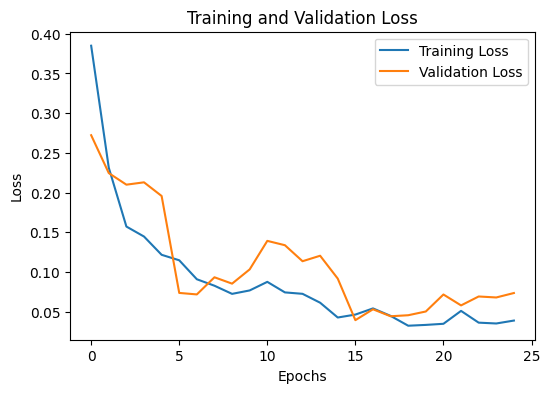

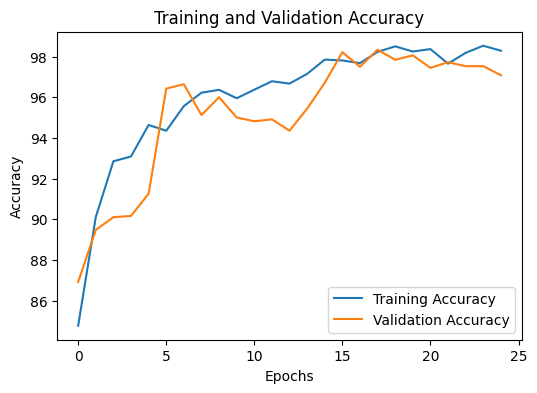

In [127]:
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [128]:
model.evaluate_model(genealogy_test_encodings, genealogy_test_labels_array)

Final Accuracy: 91.04%


In [129]:
predictions = model.predict(genealogy_test_encodings)

In [131]:
true_positives = dict()
false_positives = dict()
false_negatives = dict()
for i in range(len(genealogy_test_texts)):
    window = min(len(genealogy_test_texts[i]), len(predictions[i]) - 1)
    predicted_labels = encoder.inverse_transform(predictions[i].cpu()[1:window])
    true_labels = encoder.inverse_transform(genealogy_test_labels_array[i][1:window])
    for true, pred in zip(true_labels, predicted_labels):
        if true == pred:
            if true in true_positives:
                true_positives[true] += 1
            else:
                true_positives[true] = 1
        else:
            if pred in false_positives:
                false_positives[pred] += 1
            else:
                false_positives[pred] = 1
            if true in false_negatives:
                false_negatives[true] += 1
            else:
                false_negatives[true] = 1
precision = dict()
recall = dict()
for label in encoder.classes_:
    if true_positives[label] + false_positives[label] > 0:
        precision[label] = true_positives[label] / (true_positives[label] + false_positives[label])
    else:
        precision[label] = 0.0
    if true_positives[label] + false_negatives[label] > 0:
        recall[label] = true_positives[label] / (true_positives[label] + false_negatives[label])
    else:
        recall[label] = 0.0

overall_precision = np.mean(list(precision.values()))
overall_recall = np.mean(list(recall.values()))

for label in encoder.classes_:
    print(f"{label}")
    print(f"Precision: {precision[label]:.4f}")
    print(f"Recall: {recall[label]:.4f}")
    print(f"F1 Score: {2 * (precision[label] * recall[label]) / (precision[label] + recall[label]):.4f}")
    print()

print(f"Overall Precision (Macro-Averaged): {overall_precision:.4f}")
print(f"Overall Recall (Macro-Averaged): {overall_recall:.4f}")
print(f"Overall F1 Score: {2 * (overall_precision * overall_recall) / (overall_precision + overall_recall):.4f}")

B-LOC
Precision: 0.7055
Recall: 0.8483
F1 Score: 0.7704

B-PERSON
Precision: 0.9099
Recall: 0.8682
F1 Score: 0.8886

B-TIME
Precision: 0.8459
Recall: 0.7841
F1 Score: 0.8138

I-LOC
Precision: 0.7717
Recall: 0.8697
F1 Score: 0.8178

I-PERSON
Precision: 0.9092
Recall: 0.8653
F1 Score: 0.8867

I-TIME
Precision: 0.7294
Recall: 0.9771
F1 Score: 0.8353

O
Precision: 0.9480
Recall: 0.9107
F1 Score: 0.9290

Overall Precision (Macro-Averaged): 0.8314
Overall Recall (Macro-Averaged): 0.8748
Overall F1 Score: 0.8525


In [ ]:
torch.save(model.state_dict(), './drive/MyDrive/Colab Notebooks/chinese-genealogy/bert-ancient-chinese-base.pt')